['test', 'train']
Número de GPUs disponibles: 1
Detalle de GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Clases de las imágenes:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Epoch 1/20
897/897 [==============================] - 169s 175ms/step - loss: 1.7065 - accuracy: 0.3510 - val_loss: 1.4151 - val_accuracy: 0.4452
Epoch 2/20
897/897 [==============================] - 155s 173ms/step - loss: 1.4771 - accuracy: 0.4375 - val_loss: 1.3445 - val_accuracy: 0.4934
Epoch 3/20
897/897 [==============================] - 168s 187ms/step - loss: 1.4305 - accuracy: 0.4544 - val_loss: 1.2649 - val_accuracy: 0.5140
Epoch 4/20
897/897 [==============================] - 156s 174ms/step - loss: 1.3919 - accuracy: 0.4772 - val_loss: 1.4080 - val_accuracy: 0.4820
Epoch 5/20
897/897 [==============================] - 154s 171ms/step - loss: 1.3769 - a

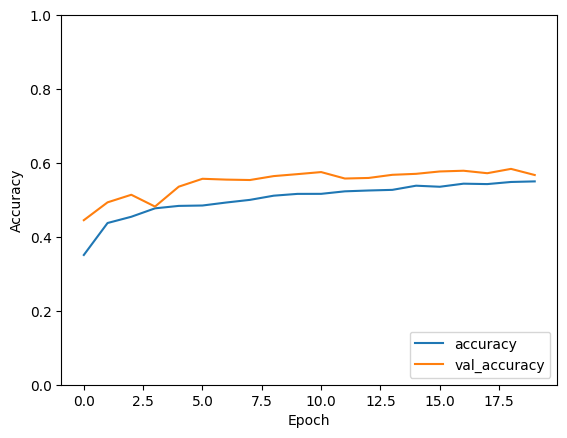

In [2]:
import os
import pathlib
import ipykernel
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import scipy

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Obtener la ruta actual del notebook
notebook_path = pathlib.Path(ipykernel.get_connection_file()).parent.resolve()

folder_path = 'dataset'
print(os.listdir(folder_path))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(f'Número de GPUs disponibles: {len(gpus)}')
    for gpu in gpus:
        print(f'Detalle de GPU: {gpu}')
else:
    print('No se encontraron GPUs disponibles.')

# Definir tamaño de las imágenes
img_width, img_height = 150, 150

# Preparar los generadores de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    #contrast_stretching=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(folder_path, 'train'),
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(folder_path, 'test'),
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

print("Clases de las imágenes: ", train_generator.class_indices)

# Crear el modelo InceptionResNetV2
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = True

# Congelar todas las capas del modelo base, excepto las últimas 50
for layer in base_model.layers[:-50]:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=20  # Aumentar el número de épocas
)

# Evaluar el modelo
loss, accuracy = model.evaluate(test_generator)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

# Guardar el modelo
model.save('modelo_inception_resnet.h5')

# Guardar el historial del entrenamiento
import pickle
with open('historia_entrenamiento.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# Visualizar el progreso del entrenamiento
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [3]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load the image
img_path = 'prueba.jpg'
img = load_img(img_path, target_size=(img_width, img_height))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0

# Make predictions
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Print the classification
print(f"The predicted class is: {predicted_class}")

1/1 [==============================] - 4s 4s/step
The predicted class is: 3


In [4]:
from keras.models import load_model

# Cargar el modelo guardado
model = load_model('modelo_inception_resnet.h5')

# Continuar el entrenamiento
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=10  # Define cuántas épocas adicionales quieres entrenar
)

# Guardar el modelo nuevamente después del entrenamiento adicional
model.save('modelo_inception_resnet_continuado.h5')


Epoch 1/10
897/897 [==============================] - 156s 169ms/step - loss: 1.1932 - accuracy: 0.5588 - val_loss: 1.1611 - val_accuracy: 0.5605
Epoch 2/10
897/897 [==============================] - 169s 188ms/step - loss: 1.1997 - accuracy: 0.5546 - val_loss: 1.1448 - val_accuracy: 0.5765
Epoch 3/10
897/897 [==============================] - 148s 165ms/step - loss: 1.1956 - accuracy: 0.5555 - val_loss: 1.1563 - val_accuracy: 0.5698
Epoch 4/10
897/897 [==============================] - 308s 344ms/step - loss: 1.1914 - accuracy: 0.5546 - val_loss: 1.1294 - val_accuracy: 0.5777
Epoch 5/10
897/897 [==============================] - 242s 269ms/step - loss: 1.1980 - accuracy: 0.5571 - val_loss: 1.1083 - val_accuracy: 0.5852
Epoch 6/10
897/897 [==============================] - 165s 184ms/step - loss: 1.1826 - accuracy: 0.5610 - val_loss: 1.0943 - val_accuracy: 0.5905
Epoch 7/10
897/897 [==============================] - 147s 164ms/step - loss: 1.1797 - accuracy: 0.5598 - val_loss: 1.0966 -

In [6]:
import os
from keras.models import load_model
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

# Ajuste de la tasa de aprendizaje
learning_rate = 0.0001  # Prueba con diferentes valores
optimizer = Adam(learning_rate=learning_rate)

# Cargar el modelo guardado
model = load_model('modelo_inception_resnet.h5')

# Añadir capas de regularización adicionales si es necesario
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Configurar el aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,  # Añadir rotación
    width_shift_range=0.2,  # Desplazamiento horizontal
    height_shift_range=0.2  # Desplazamiento vertical
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(folder_path, 'train'),
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(folder_path, 'test'),
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

# Configurar EarlyStopping y ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Continuar el entrenamiento
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=10,  # Incrementar el número de épocas
    callbacks=[early_stopping, checkpoint]
)

# Guardar el modelo nuevamente después del entrenamiento adicional
model.save('modelo_inception_resnet_continuado.h5')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/20
897/897 [==============================] - 168s 177ms/step - loss: 1.5424 - accuracy: 0.5269 - val_loss: 1.2734 - val_accuracy: 0.5788
Epoch 2/20
897/897 [==============================] - 157s 175ms/step - loss: 1.2642 - accuracy: 0.5672 - val_loss: 1.1935 - val_accuracy: 0.5838
Epoch 3/20
897/897 [==============================] - 157s 174ms/step - loss: 1.2315 - accuracy: 0.5685 - val_loss: 1.1668 - val_accuracy: 0.5896
Epoch 4/20
897/897 [==============================] - 160s 178ms/step - loss: 1.2146 - accuracy: 0.5685 - val_loss: 1.1559 - val_accuracy: 0.5876
Epoch 5/20
897/897 [==============================] - 247s 275ms/step - loss: 1.2051 - accuracy: 0.5718 - val_loss: 1.1556 - val_accuracy: 0.5864
Epoch 6/20
897/897 [==============================] - 372s 414ms/step - loss: 1.1938 - accuracy: 0.5758 - val_loss: 1.1432 - val_accuracy: 0.5943
Epoch 7/20
897/897 [===================

In [ ]:
import os
from keras.models import load_model
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

# Ajuste de la tasa de aprendizaje
learning_rate = 0.0001  # Prueba con diferentes valores
optimizer = Adam(learning_rate=learning_rate)

# Cargar el modelo guardado
model = load_model('modelo_inception_resnet.h5')

# Añadir capas de regularización adicionales si es necesario
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Configurar el aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,  # Añadir rotación
    width_shift_range=0.2,  # Desplazamiento horizontal
    height_shift_range=0.2  # Desplazamiento vertical
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(folder_path, 'train'),
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(folder_path, 'test'),
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

# Configurar EarlyStopping y ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Continuar el entrenamiento
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=10,  # Incrementar el número de épocas
    callbacks=[early_stopping, checkpoint]
)

# Guardar el modelo nuevamente después del entrenamiento adicional
model.save('modelo_inception_resnet_continuado.h5')


In [ ]:
import matplotlib.pyplot as plt

# Cargar la historia del entrenamiento
history = model.fit(...)

# Graficar precisión
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

# Graficar pérdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()
